# Plots

In [9]:
import pandas as pd
import json
from tqdm import tqdm
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
import stopwordsiso as stopwords
import pickle
class Languages:
    esga = 'ES-GA'
    si = 'SI'
    gb = 'GB'
    hu = 'HU'
    ua = 'UA'
    all = [esga, si, gb, hu, ua]

class Topics:
    healthcare = 'healthcare'
    war = 'war'
    eu = 'eu'
    all = [healthcare, war, eu]

In [43]:
sentences = {}
for language in Languages.all:
    print('loading', language)
    sentences[language] = pd.read_feather(f'artefacts/pandas_frames/{language}_parlamint_sentences.feather')
metadata = pd.read_feather('artefacts/pandas_frames/parlamint_metadata.feather')

for language in tqdm(Languages.all):
    sentences[language].speech_id = sentences[language].speech_id.apply(lambda x: x.replace('.ana', ''))

loading ES-GA
loading SI
loading GB
loading HU
loading UA


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


In [37]:
artefacts_base = Path('artefacts/bojan')
files = {
    Languages.si: 'ParlaMint-SI_with_sentiment.csv',
    Languages.ua: 'ParlaMint-UA_with_sentiment.csv',
    Languages.hu: 'ParlaMint-HU_with_sentiment.csv',
    Languages.gb: 'ParlaMint-GB-commons_with_sentiment.csv',
}
filtered_speeches = {}
filtered_speech_ids = set()
for language, csv_file in files.items():
    lang_df = pd.read_csv(artefacts_base / csv_file)
    print('loaded', language, 'len =', len(lang_df))
    lang_df = lang_df[lang_df['Speaker_role'] == 'Regular']
    lang_df = lang_df[lang_df['Speaker_MP'] == 'MP']
    lang_df['speech_length'] = lang_df['speech'].apply(lambda x: len(x) if type(x) == str else 0)
    lang_df = lang_df[lang_df['speech_length'] > 200]
    filtered_speech_ids.update(lang_df.ID)
    filtered_speeches[language] = lang_df

loaded SI len = 311354
loaded UA len = 195685


/tmp/ipykernel_649818/2632164922.py:11: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  lang_df = pd.read_csv(artefacts_base / csv_file)


loaded HU len = 104521
loaded GB len = 472782


In [44]:
topics = {}
artefacts_by_topic = lambda t, l: Path(f'artefacts/by_topic/topic_csvs/{t}_{l}.csv')
for topic in tqdm(Topics.all):
    for language in Languages.all:
        csv_path = artefacts_by_topic(topic, language)
        if not csv_path.exists():
            continue
        df = pd.read_csv(csv_path)
        topics.setdefault(topic, {})[language] = df
        df.Date = pd.to_datetime(df.Date)
topics[Topics.eu][Languages.si]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.75s/it]


,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-SI_2017-07-10-SDZ7-Redna-32.u192,Minutes of the National Assembly of the Republ...,2017-07-10,Lower house,7,NaN,32,NaN,NaN,Reference,...,Levica,Levica,Opposition,"Tomić, Violeta",F,1963,"Hvala za besedo, predsedujoči. Kolegice in kol...",Kolegice in kolegi! Izgradnja belokranjskega ...,-0.905273,1791
1,ParlaMint-SI_2017-09-21-SDZ7-Redna-33.u16,Minutes of the National Assembly of the Republ...,2017-09-21,Lower house,7,NaN,33,NaN,NaN,Reference,...,NSi,Nova Slovenija – Krščanski demokrati,Opposition,"Horvat, Jožef",M,1955,"Hvala lepa za besedo, spoštovani gospod predse...","Spoštovani gospod državni sekretar, drage kol...",0.307861,3460
2,ParlaMint-SI_2017-11-16-SDZ7-Redna-35.u68,Minutes of the National Assembly of the Republ...,2017-11-16,Lower house,7,NaN,35,NaN,NaN,Reference,...,NSi,Nova Slovenija – Krščanski demokrati,Opposition,"Dimic, Iva",F,1972,"Lepo pozdravljeni! Mislim, da se v Državnem zb...",Področje razvoja podeželja se mi zdi pomembno...,0.209839,1122
3,ParlaMint-SI_2017-11-21-SDZ7-Redna-35.u126,Minutes of the National Assembly of the Republ...,2017-11-21,Lower house,7,NaN,35,NaN,NaN,Reference,...,Levica,Levica,Opposition,"Tomić, Violeta",F,1963,"Najlepša hvala za besedo, predsedujoči. Veseli...","Veseli me, da vam lahko predstavim dopolnilno...",-0.335205,4227
4,ParlaMint-SI_2017-11-21-SDZ7-Redna-35.u144,Minutes of the National Assembly of the Republ...,2017-11-21,Lower house,7,NaN,35,NaN,NaN,Reference,...,SMC,Stranka modernega centra,Coalition,"Ranc, Danilo Anton",M,1957,"Spoštovani predsedujoči, spoštovani predstavni...",V Poslanski skupini modernega centra se zaved...,-0.066711,3749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,ParlaMint-SI_2003-10-28-SDZ3-Redna-30.u51,Minutes of the National Assembly of the Republ...,2003-10-28,Lower house,3,NaN,30,NaN,NaN,Reference,...,SMS,Stranka mladih Slovenije,Coalition,"Diaci, Marko",M,1971,Hvala za besedo. Lep pozdrav vsem prisotnim! S...,Lep pozdrav vsem prisotnim! S predlogom zakon...,-0.177856,6315
5134,ParlaMint-SI_2003-10-28-SDZ3-Redna-30.u194,Minutes of the National Assembly of the Republ...,2003-10-28,Lower house,3,NaN,30,NaN,NaN,Reference,...,LDS,Liberalna demokracija Slovenije,Coalition,"Anderlič, Anton",M,1956,"Spoštovani! Obžalujem, da noben minister za km...","Zato je bilo skoraj nujno, da k predlaganju t...",0.237183,4193
5135,ParlaMint-SI_2003-12-16-SDZ3-Redna-32.u150,Minutes of the National Assembly of the Republ...,2003-12-16,Lower house,3,NaN,32,NaN,NaN,Reference,...,SLS,Slovenska ljudska stranka,Coalition,"Rokavec, Franci",M,1963,"Hvala za besedo, gospod podpredsednik. Spoštov...","Spoštovana gospa ministrica, poslanke in posl...",-0.504883,4165
5136,ParlaMint-SI_2003-12-16-SDZ3-Redna-32.u234,Minutes of the National Assembly of the Republ...,2003-12-16,Lower house,3,NaN,32,NaN,NaN,Reference,...,NSi,Nova Slovenija – Krščanski demokrati,Opposition,"Sok, Alojz",M,1959,"Hvala lepa za besedo. Torej čisto tako, kot po...","Torej čisto tako, kot poslušam danes, smo gov...",-0.654297,2424


In [45]:
# Prepare a dictionary to hold total counts for each language
total_counts = {}

for language, df in filtered_speeches.items():
    if df['Date'].dtype != 'datetime64[ns]':
        df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] >= '2015-01-01']
    total_counts[language] = df.resample('Q', on='Date').count()['speech']

## Raw counts

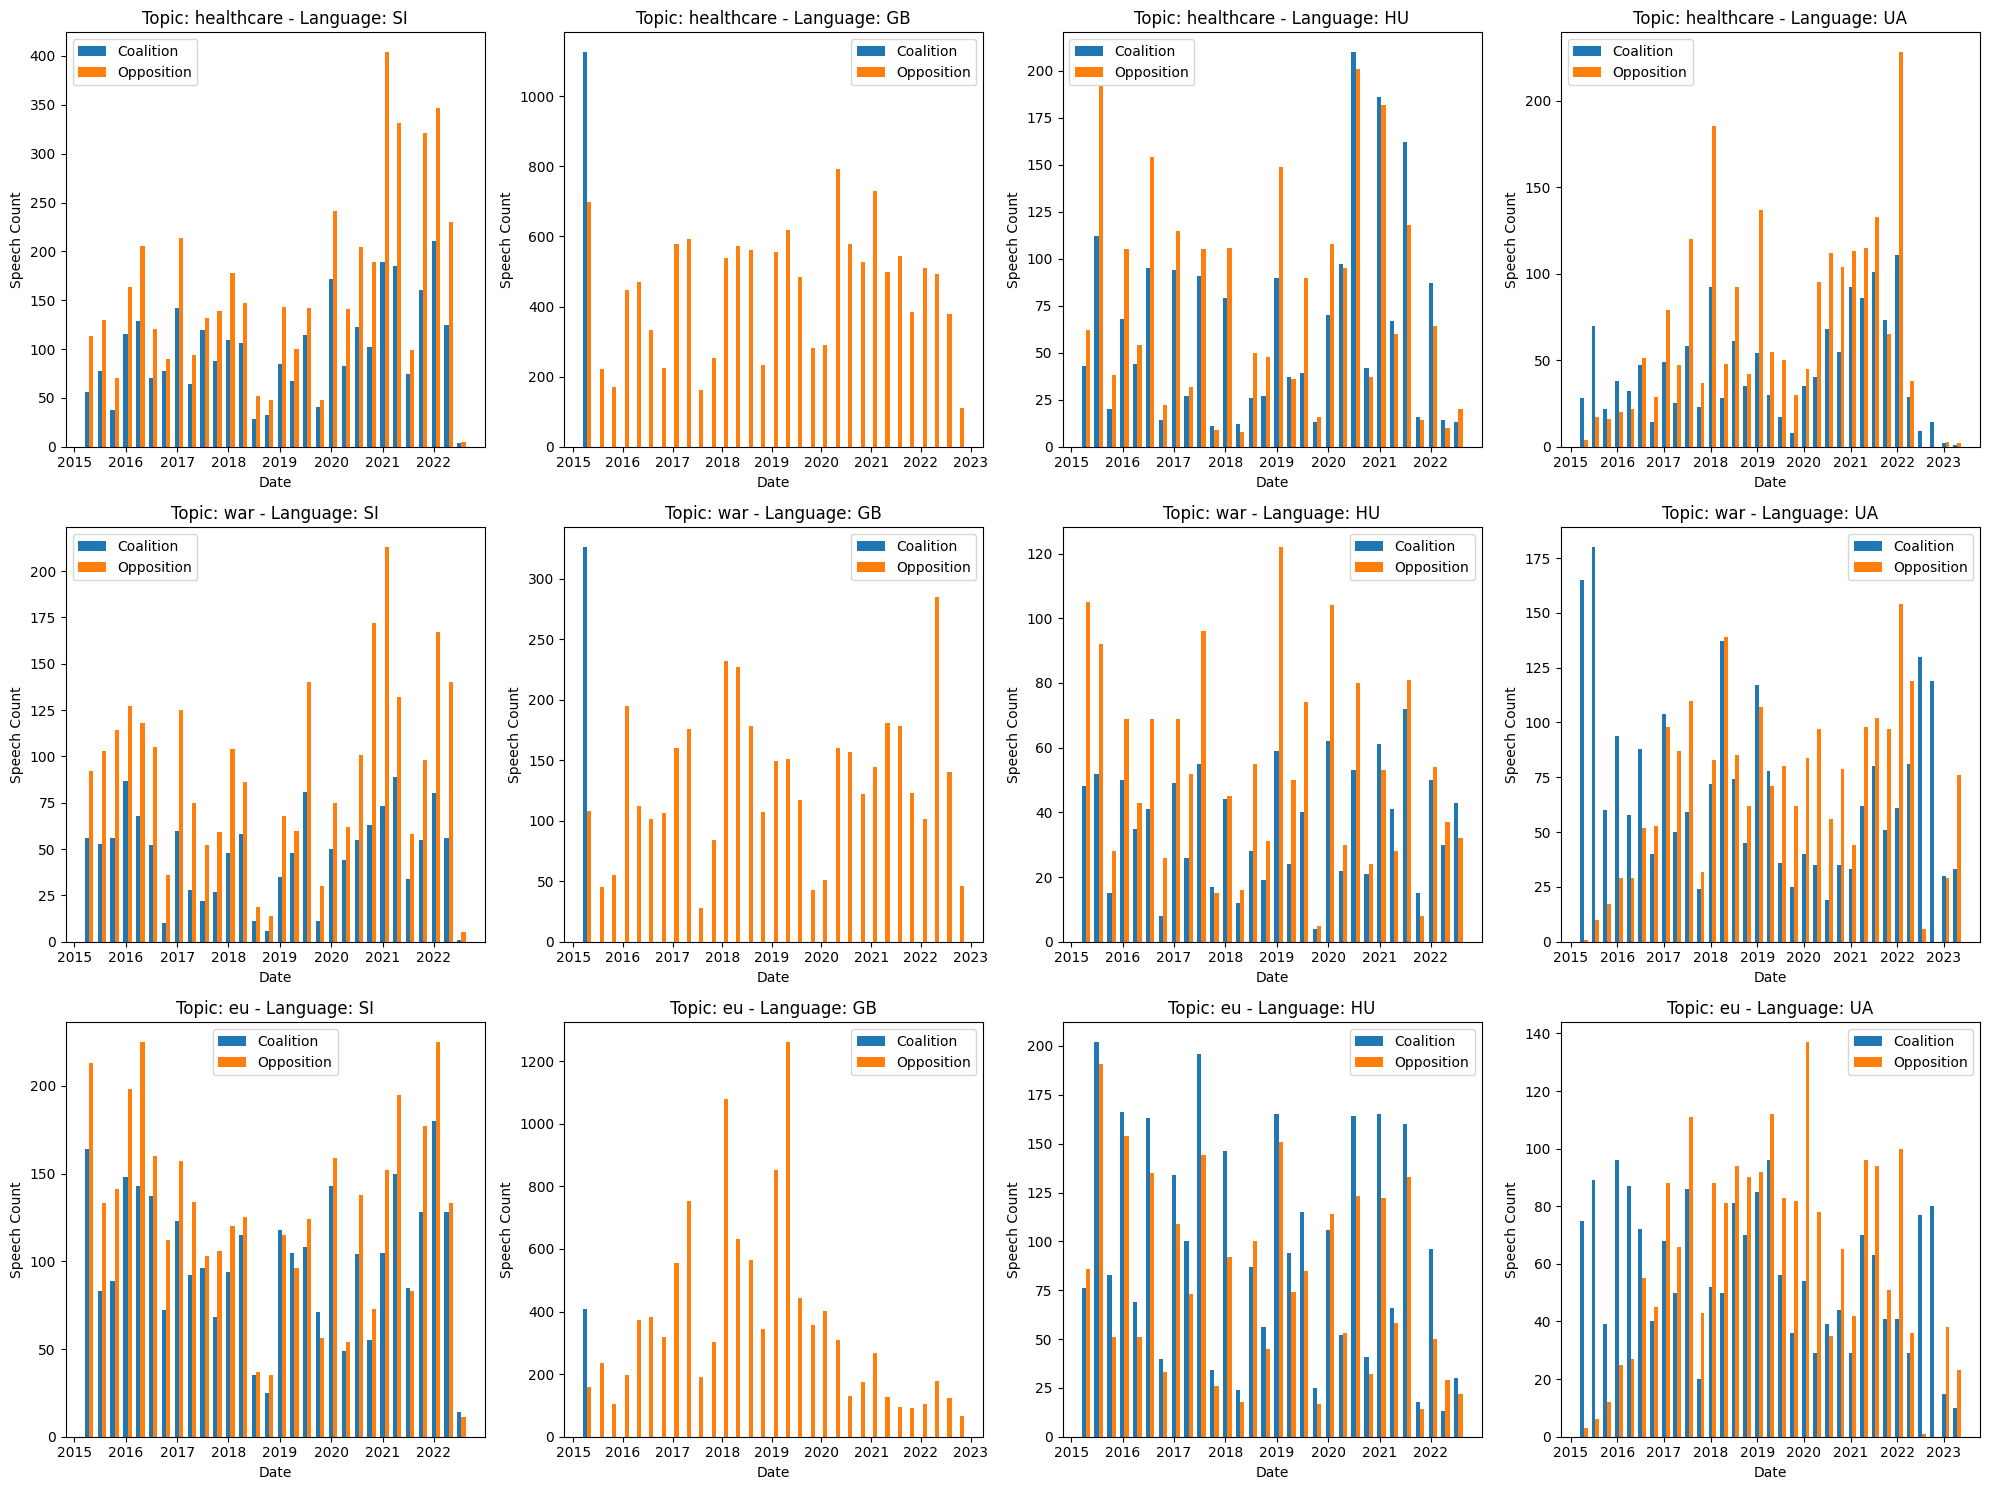

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Count total number of dataframes
total_dfs = sum(len(v) for v in topics.values())

# Calculate number of rows and columns for the grid
n_cols = 4  # You can change this value as per your need
n_rows = total_dfs // n_cols
n_rows += total_dfs % n_cols

# Create figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Adjust size as per your need
axs = axs.ravel()  # Flatten the axes array

# Bar width in days (quarter = 91 days)
bar_width = 30

# Iterate through topics and languages, plotting each dataframe
i = 0
for topic, language_data in topics.items():
    for language, df in language_data.items():
        # Convert 'Date' column to datetime if it's not already
        if df['Date'].dtype != 'datetime64[ns]':
            df['Date'] = pd.to_datetime(df['Date'])

        # Filter data from 2015 onwards
        df = df[df['Date'] >= '2015-01-01']

        # Resample data to get counts per quarter and group by Party_status
        quarterly_counts = df.groupby('Party_status').resample('Q', on='Date').count()['speech']
        coalition_counts = quarterly_counts.loc['Coalition']
        opposition_counts = quarterly_counts.loc['Opposition']

        # Calculate x coordinates for the bars
        x_coalition = coalition_counts.index - DateOffset(days=bar_width//2)
        x_opposition = opposition_counts.index + DateOffset(days=bar_width//2)

        # Plot data
        axs[i].bar(x_coalition, coalition_counts.values, width=bar_width, align='edge', label='Coalition')
        axs[i].bar(x_opposition, opposition_counts.values, width=bar_width, align='edge', label='Opposition')
        axs[i].set_title(f'Topic: {topic} - Language: {language}')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Speech Count')
        axs[i].legend()

        i += 1

# Remove unused subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])
plt.savefig('artefacts/plots/parlamint_topics_per_time.png', dpi=300)
plt.tight_layout()
plt.show()


## Percentage of all speeches

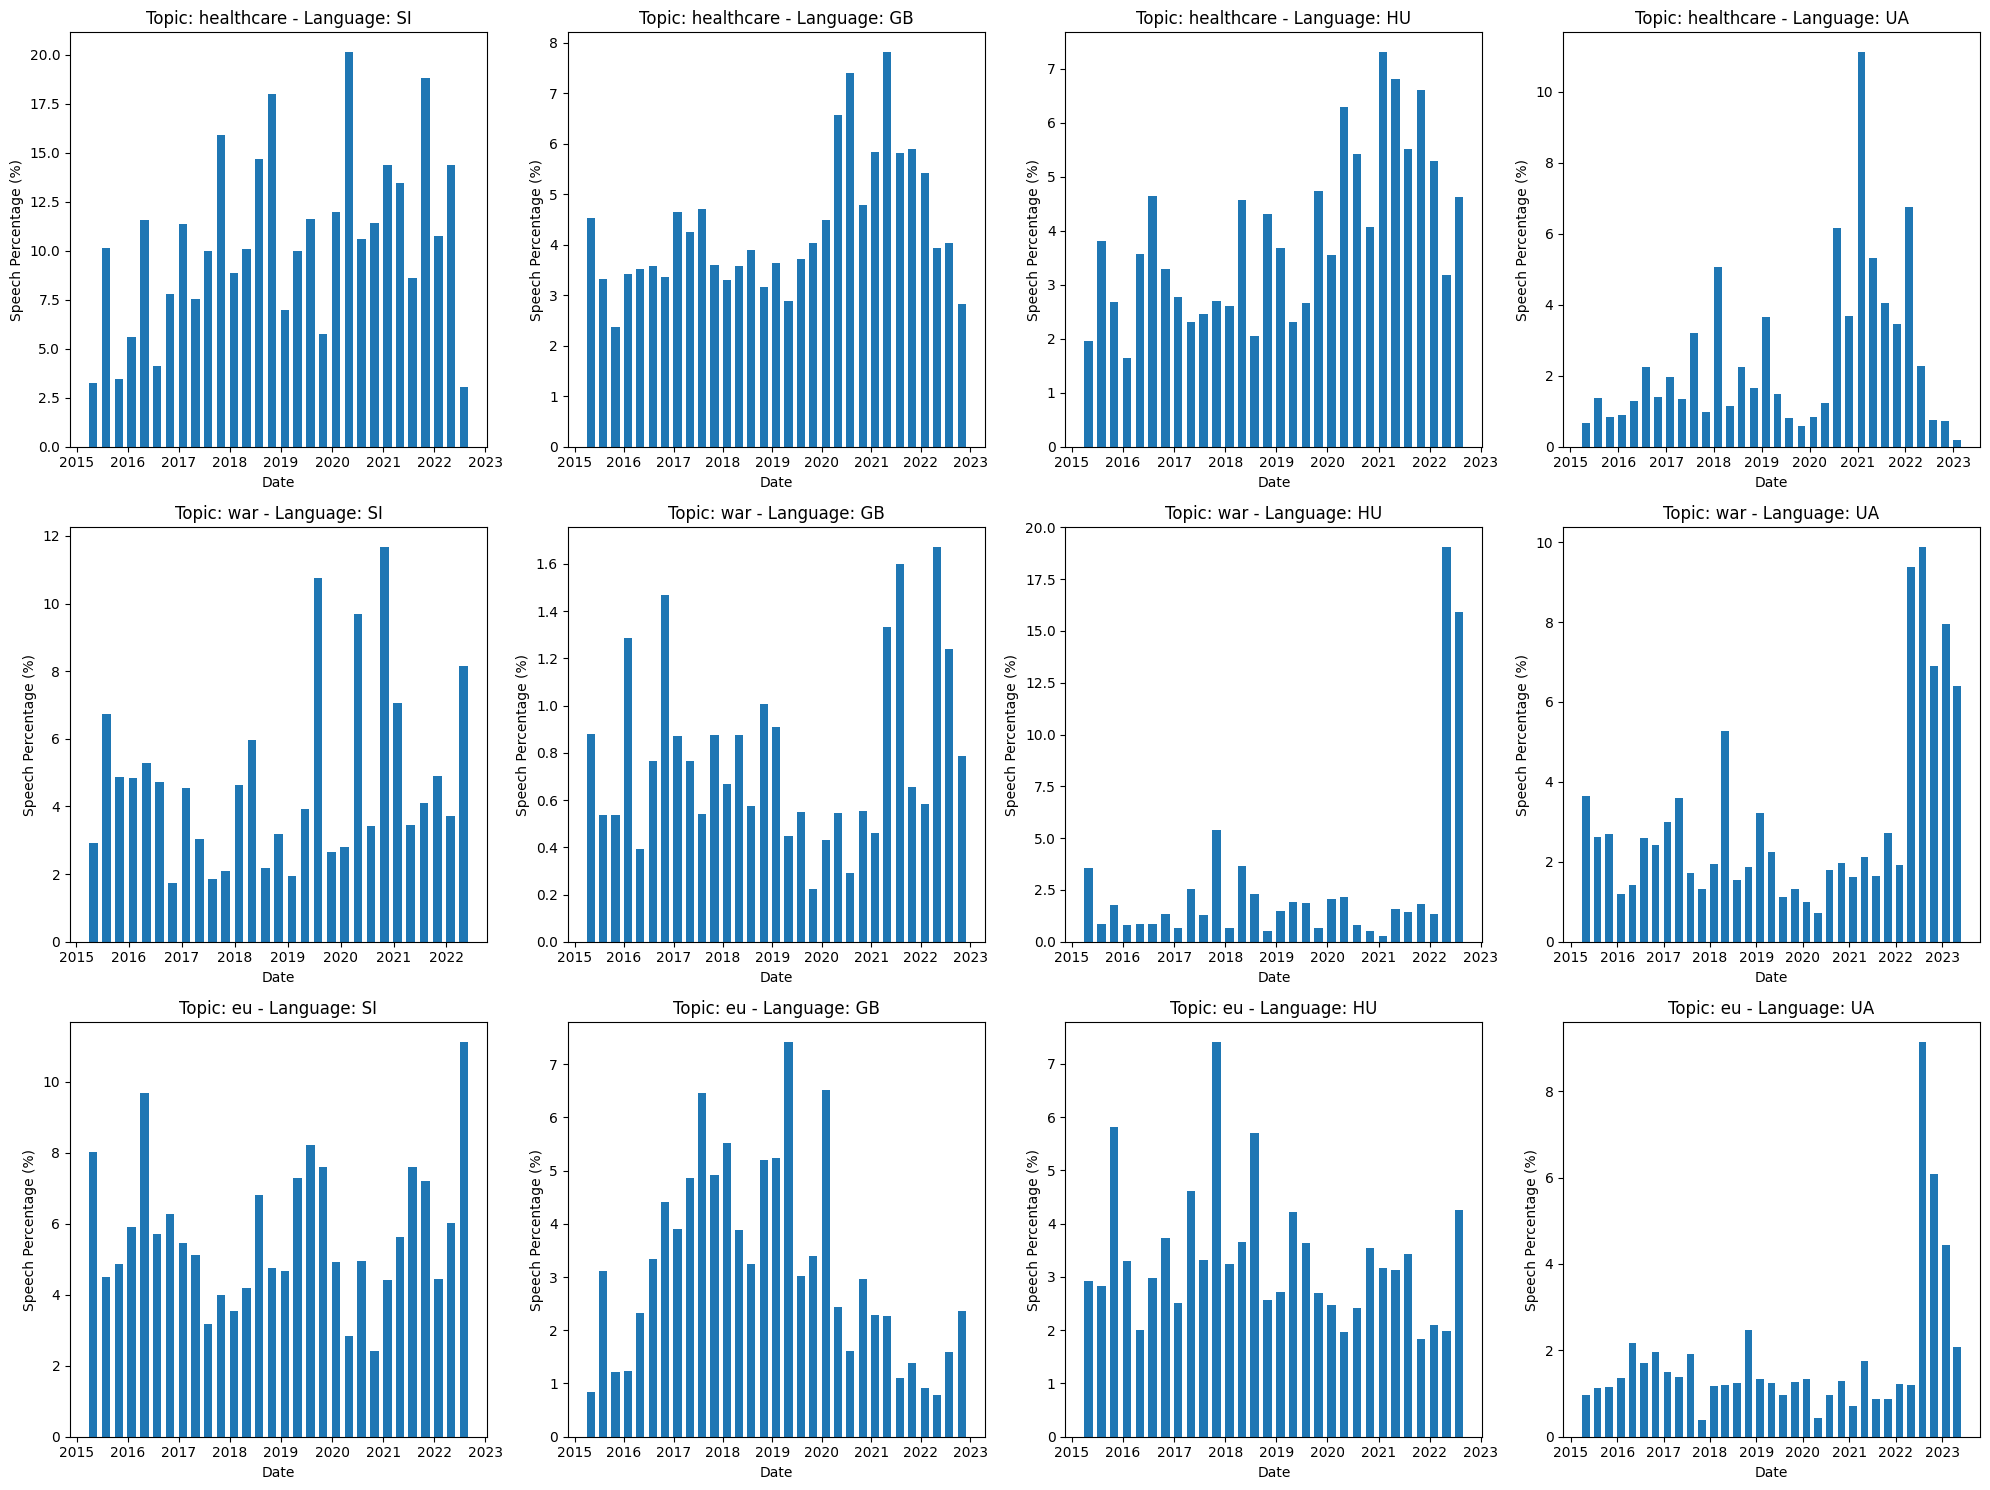

In [46]:
# Count total number of dataframes
total_dfs = sum(len(v) for v in topics.values())

# Calculate number of rows and columns for the grid
n_cols = 4  # You can change this value as per your need
n_rows = total_dfs // n_cols
n_rows += total_dfs % n_cols

# Create figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Adjust size as per your need
axs = axs.ravel()  # Flatten the axes array

# Iterate through topics and languages, plotting each dataframe
i = 0
for topic, language_data in topics.items():
    for language, df in language_data.items():
        # Convert 'Date' column to datetime if it's not already
        if df['Date'].dtype != 'datetime64[ns]':
            df['Date'] = pd.to_datetime(df['Date'])

        # Filter data from 2015 onwards
        df = df[df['Date'] >= '2015-01-01']

        # Resample data to get counts per quarter
        quarterly_counts = df.resample('Q', on='Date').count()['speech']

        # Calculate percentages
        quarterly_percentages = (quarterly_counts / total_counts[language]) * 100

        # Plot data
        axs[i].bar(quarterly_percentages.index, quarterly_percentages.values, width=60, align='edge')
        axs[i].set_title(f'Topic: {topic} - Language: {language}')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Speech Percentage (%)')

        i += 1

# Remove unused subplots
for j in range(i, n_rows * n_cols):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig('artefacts/plots/parlamint_topics_per_time_ratios.png', dpi=300)
plt.show()